In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-bvp-linear)=
# Collocation for linear problems

Let us now devise a numerical method based on finite differences for the linear TPBVP

:::{math}
  :label: linbvp
  u'' + p(x)u' + q(x)u = r(x), \quad u(a)=\alpha,\; u(b)=\beta.
:::

```{index} finite differences; for boundary value problems
```
The first step is to select nodes $x_0=a < x_1< \cdots < x_n=b$. For finite differences these will most likely be equally spaced, but for spectral differentiation they will be Chebyshev points.

Rather than solving for a function, we will solve for a vector of its approximate values at the nodes:

:::{math}
	:label: bvpsolndisc
    \mathbf{u} =
    \begin{bmatrix}
        u_0 \\ u_1 \\ \vdots \\ u_{n-1} \\ u_n
    \end{bmatrix} \approx
    \begin{bmatrix}
        \hat{u}(x_0) \\ \hat{u}(x_1) \\ \vdots \\ \hat{u}(x_{n-1}) \\ \hat{u}(x_{n})
      \end{bmatrix},
:::

where $\hat{u}$ is the exact solution of {eq}`linbvp`. If we so desire, we can use interpolation to convert the values $(x_i,u_i)$ into a function after the solution is found.

## Collocation

```{index} ! collocation
```
Having defined values at the nodes as our unknowns, we impose approximations to the ODE at the same nodes.  This approach is known as **collocation**. Derivatives of the solution are found using differentiation matrices. For example,

:::{math}
  :label: bvpD1
    \begin{bmatrix}
        \hat{u}'(x_0) \\[1mm] \hat{u}'(x_1) \\ \vdots \\ \hat{u}'(x_n)
    \end{bmatrix} \approx \mathbf{u}' = \mathbf{D}_x \mathbf{u},
:::

with an appropriately chosen differentiation matrix $\mathbf{D}_x$. Similarly, we define

:::{math}
  :label: bvpD2
    \begin{bmatrix}
        \hat{u}''(x_0) \\[1mm] \hat{u}''(x_1) \\ \vdots \\ \hat{u}''(x_n)
    \end{bmatrix} \approx \mathbf{u}'' = \mathbf{D}_{xx} \mathbf{u},
:::

with $\mathbf{D}_{xx}$ chosen in accordance with the node set.

The discrete form of {eq}`linbvp` at the $n+1$ chosen nodes is

:::{math}
    :label: fdlin2
    \mathbf{u}'' + \mathbf{P}\mathbf{u}' + \mathbf{Q}\mathbf{u} = \mathbf{r},
:::

where

:::{math}
  :label: fdlincoeff
  \begin{split}
  \mathbf{P} &= \begin{bmatrix}
        p(x_0) &  & \\
        & \ddots & \\
        & & p(x_{n})
    \end{bmatrix},
    \qquad
    \mathbf{Q} =
    \begin{bmatrix}
        q(x_0) &  & \\
        & \ddots & \\
        & & q(x_{n})
    \end{bmatrix},\\
    \mathbf{r} &= \begin{bmatrix}
        r(x_0) \\ \vdots  \\ r(x_n)
    \end{bmatrix}.
\end{split}
:::

If we apply the definitions of $\mathbf{u}'$ and $\mathbf{u}''$ and rearrange, we obtain

:::{math}
  :label: fdlinnobc
  \mathbf{L} \mathbf{u} = \mathbf{r}, \qquad \mathbf{L} =  \mathbf{D}_{xx} + \mathbf{P}\mathbf{D}_x + \mathbf{Q},
:::

which is a linear system of $n+1$ equations in $n+1$ unknowns.

```{index} boundary conditions; numerical implementation of
```

We have not yet incorporated the boundary conditions. Those take the form of the additional linear conditions $u_0=\alpha$ and $u_n=\beta$. We might regard this situation as an overdetermined system, suitable for linear least-squares. However, it's usually preferred to impose the boundary conditions and collocation conditions exactly, so we need to discard two of the collocation equations to keep the system square. The obvious candidates for deletion are the collocation conditions at the two endpoints. We may express these deletions by means of a matrix that is an $(n+1)\times(n+1)$ identity with the first and last rows deleted:

:::{math}
  :label: rowdeletion
  \mathbf{E} =
  \begin{bmatrix}
  	0      & 1      & 0      & \cdots & 0      \\
  	\vdots &        & \ddots &        & \vdots \\
  	0      & \cdots & 0      & 1      & 0
  \end{bmatrix}
  =
  \begin{bmatrix}
    \mathbf{e}_1^T    \\ \vdots \\ \mathbf{e}_{n-1}^T
  \end{bmatrix},
:::

where as always $\mathbf{e}_k$ is the $k$th column (here starting from $k=0$) of an identity matrix. The product $\mathbf{E} \mathbf{A}$ deletes the first and last rows of $\mathbf{A}$, leaving a matrix that is $(n-1)\times(n+1)$. Similarly, $\mathbf{E}\mathbf{r}$ deletes the first and last rows of $\mathbf{r}$.

Finally, we note that $\hat{u}(a)= \mathbf{e}_0^T\mathbf{u}$ and $\hat{u}(b)= \mathbf{e}_n^T\mathbf{u}$, so the linear system including both the ODE and the boundary condition collocations is

:::{math}
  :label: fdlinbc
  \begin{bmatrix}
    \mathbf{e}_0^T \\[1mm] \mathbf{E}\mathbf{L} \\[1mm]  \mathbf{e}_n^T
  \end{bmatrix}
  \mathbf{u}
  =
  \begin{bmatrix}
  \alpha \\[1mm] \mathbf{E}\mathbf{r} \\[1mm]  \beta
  \end{bmatrix} \qquad \text{or} \qquad \mathbf{A}\mathbf{u} = \mathbf{b}.
:::

## Implementation

Our implementation of linear collocation is {numref}`Function {number} <function-bvplin>`. It uses second-order finite differences but makes no attempt to exploit the sparsity of the matrices. It would be trivial to change the function to use spectral differentiation. 

(function-bvplin)=
````{proof:function} bvplin
**Solution of a linear boundary-value problem**
```{code-block} julia1
:lineno-start: 1
"""
    bvplin(p,q,r,xspan,lval,rval,n)

Use finite differences to solve a linear boundary value problem.
The ODE is u''+`p`(x)u'+`q`(x)u = `r`(x) on the interval `xspan`,
with endpoint function values given as `lval` and `rval`. There will
be `n`+1 equally spaced nodes, including the endpoints.

Returns vectors of the nodes and the solution values.
"""
function bvplin(p,q,r,xspan,lval,rval,n)
    x,Dₓ,Dₓₓ = diffmat2(n,xspan)

    P = diagm(p.(x))
    Q = diagm(q.(x))
    L = Dₓₓ + P*Dₓ + Q     # ODE expressed at the nodes

    # Replace first and last rows using boundary conditions.
    z = zeros(1,n)
    A = [ [1 z]; L[2:n,:]; [z 1] ]
    b = [ lval; r.(x[2:n]); rval ]

    # Solve the system.
    u = A\b
    return x,u
end
```
````

::::{admonition} About the code
:class: dropdown
Note that there is no need to explicitly form the row-deletion matrix $\mathbf{E}$ from {eq}`rowdeletion`. Since it only appears as left-multiplying $\mathbf{L}$ or $\mathbf{r}$, we simply perform the row deletions as needed using indexing.
::::

(demo-linear-solve)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We solve linear BVP  

$$ u'' - (\cos x) u' + (\sin x) u = 0, \quad u(0)=1, \; u\left(\frac{3\pi}{2}\right)=\frac{1}{e}. $$ 

Its exact solution is known:

In [2]:
exact = x -> exp(sin(x));

The problem is presented above in our standard form, so we can identify the coefficient functions in the ODE. Each should be coded as a function.

In [3]:
p = x -> -cos(x);
q = sin;
r = x -> 0;      # function, not value 

We solve the BVP and compare the result to the exact solution.

In [4]:
x,u = FNC.bvplin(p,q,r,[0,3π/2],1,exp(-1),30);

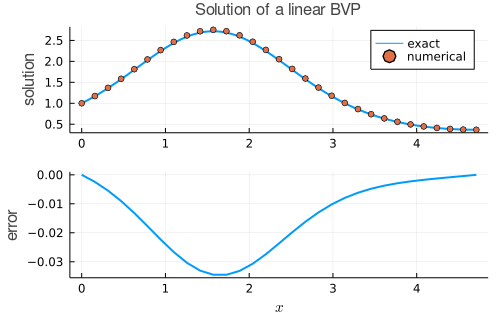

In [5]:
plot(exact,0,3π/2,layout=(2,1),label="exact")
scatter!(x,u,m=:o,subplot=1,label="numerical",
    yaxis=("solution"),title="Solution of a linear BVP")

plot!(x,exact.(x)-u,subplot=2,xaxis=L"x",yaxis=("error"))

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Accuracy and stability

We revisit {numref}`Demo %s <demo-shooting-unstable>`, which exposed instability in the shooting method, in order to verify second-order convergence.

(demo-linear-converge)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

The BVP is
  
$$
u'' - \lambda^2 u = \lambda^2, \quad  u(0)=-1, \; u(1)=0,
$$

with exact solution $\sinh(\lambda x)/\sinh(\lambda) - 1$.

In [6]:
λ = 10
exact = x -> sinh(λ*x)/sinh(λ) - 1;

The following functions define the ODE.

In [7]:
p = x -> 0
q = x -> -λ^2
r = x -> λ^2;

We compare the computed solution to the exact one for increasing $n$.

In [8]:
n = 5*[round(Int,10^d) for d in 0:.25:3]
err = zeros(size(n))
for (k,n) in enumerate(n)
    x,u = FNC.bvplin(p,q,r,[0,1],-1,0,n)    
    err[k] = norm(exact.(x)-u,Inf)
end

data = (n=n[1:4:end],err=err[1:4:end])
pretty_table(data,["n","max-norm error"])

┌──────┬────────────────┐
│    n │ max-norm error │
├──────┼────────────────┤
│    5 │      0.0362375 │
│   50 │    0.000610896 │
│  500 │      6.1311e-6 │
│ 5000 │     6.13173e-8 │
└──────┴────────────────┘


Each factor of 10 in $n$ reduces error by a factor of 100, which is indicative of second-order convergence.

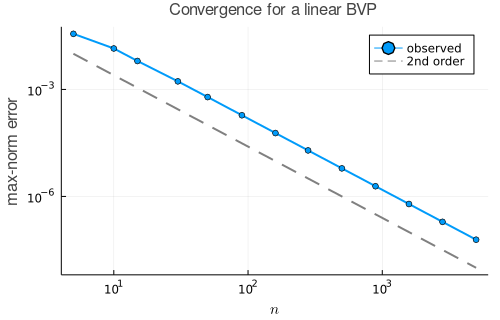

In [9]:
plot(n,err,m=:o,label="observed",
    xaxis=(:log10,L"n"), yaxis=(:log10,"max-norm error"),
    title="Convergence for a linear BVP") 
plot!(n,0.25*n.^(-2),l=(:dash,:gray),label="2nd order")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

If we write the solution $\mathbf{u}$ of Equation {eq}`fdlinbc` as the exact solution minus an error vector $\mathbf{e}$, i.e., $\mathbf{u} = \hat{\mathbf{u}} - \mathbf{e}$, we obtain

\begin{gather*}
  \mathbf{A} \hat{\mathbf{u}} - \mathbf{A} \mathbf{e} = \mathbf{b}, \\
  \mathbf{e} = \mathbf{A}^{-1} \left[  \mathbf{A} \hat{\mathbf{u}} - \mathbf{b}  \right] = \mathbf{A}^{-1} \boldsymbol{\tau}(h),
\end{gather*}

```{index} stability; of collocation
```
where $\boldsymbol{\tau}$ is the truncation error of the finite differences (except at the boundary rows, where it is zero). It follows that $\|\mathbf{e}\|$ vanishes at the same rate as the truncation error if  $\| \mathbf{A}^{-1}\|$ is bounded above as $h\to 0$. In the present context, this property is known as **stability**. Proving stability is too technical to walk through here, but stability is guaranteed under some reasonable conditions on the BVP.

## Exercises

(problem-linear-fdlin1)=
1. ✍  For each boundary-value problem, verify that the given solution is correct. Then write out by hand for $n=3$ the matrices $\mathbf{D}_{xx}$, $\mathbf{D}_x$, $\mathbf{P}$, and $\mathbf{Q}$, and the vector $\mathbf{r}$.

    **(a)** $u'' + u = 0, \quad u(0) =0, \; u(3) = \sin 3$  
    
    Solution: $u(x) = \sin x$

    **(b)** $u'' - \frac{3}{x} u' + \frac{4}{x^2} u = 0, \quad u(1) =0,\; u(4) = 32 \log 2$ 
    
    Solution: $u(x) = x^2 \log x$

    **(c)**
    $u'' - \left(x+\frac{1}{2}\right)^{-1}\, u' + 2\left(x+\frac{1}{2}\right)^{-2}\, u = 10\left(x+\frac{1}{2}\right)^{-4}, \quad u\left(x+\frac{1}{2}\right)=1,\; u\left(x+\frac{5}{2}\right) = \frac{1}{9}$
 
    Solution: $u(x) = \left(x+\frac{1}{2}\right)^{-2}$

    (problem-linear-fdlin2)=
2. ⌨  For each of the cases in the previous exercise, use {numref}`Function {number} <function-bvplin>` to solve the problem with $n=60$ and make a plot of its error as a function of $x$. Then, for each $n=10,20,40,\ldots,640$, find the infinity norm of the error. Make a log-log plot of error versus $n$ and include a graphical comparison to second-order convergence.

    (problem-linear-fdlinspec)= 
3. ⌨ Modify {numref}`Function {number} <function-bvplin>` to use spectral differentiation rather than second-order finite differences. For each of the cases in Exercise 1, solve the problem with $n=5,10,15,\ldots,40$, finding the infinity norm of the error in each case. Make a log-linear plot of error versus $n$.

    ```{index} Bessel equation
    ```
4.  ⌨ Use {numref}`Function {number} <function-bvplin>` to solve *Bessel's equation*,

    $$
    x^2 u'' + x u' + x^2 y = 0, \quad u(0.5)=1,\; u(8) = 0.
    $$

    Plot the solution for $n=100$.

    ```{index} Airy equation
    ```
5. ⌨ The *Airy equation* is $u''=x u$. Its solution is exponential for $x>0$ and oscillatory for $x<0$. The exact solution is given by $u=c_1 \operatorname{Ai}(x) + c_2 \operatorname{Bi}(x)$, where Ai and Bi are Airy functions. In Julia they are computed by `airyai` and `airybi`, respectively.

    **(a)** Suppose that $u(-10) =-1$, $u(2) =1$. By setting up and solving a $2\times 2$ linear system, find numerical values for $c_1$ and $c_2$. Plot the resulting exact solution.

    **(b)** Use {numref}`Function {number} <function-bvplin>` with $n=120$ to find the solution with the boundary conditions in part (a). In a 2-by-1 subplot array, plot the finite-difference solution and its error. (The solution is not very accurate.)
    
    **(c)** Repeat part (b) with $n=800$.

6. Consider the boundary-value problem $\epsilon u''+(1+\epsilon)u'+u =0$ over $x\in (0,1)$, with $u(0)=0$, $u(1)=1$.  As the parameter $\epsilon$ is decreased, the solution gets a thin region of high activity near $x=0$ called a *boundary layer*.

    **(a)** ✍ Verify that the exact solution to the problem is 
    
    $$
    u(x) = \frac{e^{-x}-e^{-x/\epsilon}}{e^{\,-1}-e^{\,-1/\epsilon}}.
    $$

    On one graph, plot $u(x)$ for $\epsilon=\frac{1}{4},\frac{1}{16},\frac{1}{64}$.
    
    **(b)** ⌨ Define $N(\epsilon)$ as the smallest integer value of $n$ needed to make the max-norm error of the result of {numref}`Function {number} <function-bvplin>` less than $10^{-4}$. For each of the values $\epsilon = \frac{1}{2},\frac{1}{4},\frac{1}{8}\ldots,\frac{1}{64}$, estimate $N(\epsilon)$ by starting with $n=50$ and incrementing by 25 until the measured error is sufficiently small. 
    
    **(c)** ⌨ Plot the error as a function of $x$ for $\epsilon=\frac{1}{64}$ and $n=N(\epsilon)$.  Compare the peak of the error to the graph from part (a). 
    
    **(d)** ⌨ Develop a hypothesis for the leading-order behavior of $N(\epsilon)$. Plot the observed $N(\epsilon)$ and your hypothesis together on a log-log plot.
    
    **(e)** ✍ Finite-difference errors depend on the solution as well as on $n$. Given that this error decreases as $O(n^{-2})$, what does your hypothesis for $N(\epsilon)$ suggest about the behavior of the error for fixed $n$ as $\epsilon\to 0$?